In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Utils/IOU.py


In [38]:
import numpy as np
import xml.etree.ElementTree as ET
import torch
def get_gt_boxes(xmlfile):
    '''get ground-truth bbox from VOC xml file'''
    tree = ET.parse(xmlfile)
    objs = tree.findall('object')
    num_objs = len(objs)
    gt_boxes = []
    for obj in objs:
        bbox = obj.find('bndbox')
        x1 = float(bbox.find('xmin').text)-1
        y1 = float(bbox.find('ymin').text)-1
        x2 = float(bbox.find('xmax').text)-1
        y2 = float(bbox.find('ymax').text)-1

        gt_boxes.append((x1, y1, x2, y2))
    return gt_boxes

def get_gt_boxes_only_one(xmlfile):
    '''get ground-truth bbox from VOC xml file'''
    tree = ET.parse(xmlfile)
    objs = tree.findall('object')
    num_objs = len(objs)
    gt_boxes = []
    for obj in objs:
        bbox = obj.find('bndbox')
        x1 = float(bbox.find('xmin').text)-1
        y1 = float(bbox.find('ymin').text)-1
        x2 = float(bbox.find('xmax').text)-1
        y2 = float(bbox.find('ymax').text)-1

        gt_boxes.append((x1, y1, x2, y2))
        break
    return gt_boxes

def get_cls_gt_boxes(xmlfile, cls):
    '''get ground-truth bbox from VOC xml file'''
    tree = ET.parse(xmlfile)
    objs = tree.findall('object')
    num_objs = len(objs)
    gt_boxes = []
    for obj in objs:
        bbox = obj.find('bndbox')
        cls_name = obj.find('name').text
        #print(cls_name, cls)
        if cls_name != cls:
            continue
        x1 = float(bbox.find('xmin').text)-1
        y1 = float(bbox.find('ymin').text)-1
        x2 = float(bbox.find('xmax').text)-1
        y2 = float(bbox.find('ymax').text)-1

        gt_boxes.append((x1, y1, x2, y2))
    if len(gt_boxes)==0:
        pass
        #print('%s bbox = 0'%cls)

    return gt_boxes

def get_cls_and_gt_boxes(xmlfile, cls,class_to_idx):
    '''get ground-truth bbox from VOC xml file'''
    tree = ET.parse(xmlfile)
    objs = tree.findall('object')
    num_objs = len(objs)
    gt_boxes = []
    for obj in objs:
        bbox = obj.find('bndbox')
        cls_name = obj.find('name').text
        #print(cls_name, cls)
        if cls_name != cls:
            continue
        x1 = float(bbox.find('xmin').text)-1
        y1 = float(bbox.find('ymin').text)-1
        x2 = float(bbox.find('xmax').text)-1
        y2 = float(bbox.find('ymax').text)-1

        gt_boxes.append((class_to_idx[cls_name],[x1, y1, x2-x1, y2-y1]))
    if len(gt_boxes)==0:
        pass
        #print('%s bbox = 0'%cls)

    return gt_boxes
def convert_boxes(boxes):
    ''' convert the bbox to the format (x1, y1, x2, y2) where x1,y1<x2,y2'''
    converted_boxes = []
    for bbox in boxes:
        (x1, y1, x2, y2) = bbox
        converted_boxes.append((min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)))
    return converted_boxes

def IoU(a, b):
    #print(a, b)
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    def compute_area(box):
        dx = max(0, box[2]-box[0])
        dy = max(0, box[3]-box[1])
        dx = float(dx)
        dy = float(dy)
        return dx*dy

    #print(x1, y1, x2, y2)
    w = max(0, x2-x1+1)
    h = max(0, y2-y1+1)
    #inter = w*h
    #aarea = (a[2]-a[0]+1)*(a[3]-a[1]+1)
    #barea = (b[2]-b[0]+1)*(b[3]-b[1]+1)
    inter = compute_area([x1, y1, x2, y2])
    aarea = compute_area(a)
    barea = compute_area(b)

    #assert aarea+barea-inter>0
    if aarea + barea - inter <=0:
        print(a)
        print(b)
    o = inter / (aarea+barea-inter)
    #if w<=0 or h<=0:
    #    o = 0
    return o

def to_2d_tensor(inp):
    inp = torch.Tensor(inp)
    if len(inp.size()) < 2:
        inp = inp.unsqueeze(0)
    return inp


def xywh_to_x1y1x2y2(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] += boxes[:, 0] - 1
    boxes[:, 3] += boxes[:, 1] - 1
    return boxes


def x1y1x2y2_to_xywh(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] -= boxes[:, 0] - 1
    boxes[:, 3] -= boxes[:, 1] - 1
    return boxes

def compute_IoU(pred_box, gt_box):
    boxes1 = to_2d_tensor(pred_box)
    # boxes1 = xywh_to_x1y1x2y2(boxes1)
    boxes1[:, 2] = torch.clamp(boxes1[:, 0] + boxes1[:, 2], 0, 1)
    boxes1[:, 3] = torch.clamp(boxes1[:, 1] + boxes1[:, 3], 0, 1)

    boxes2 = to_2d_tensor(gt_box)
    boxes2[:, 2] = torch.clamp(boxes2[:, 0] + boxes2[:, 2], 0, 1)
    boxes2[:, 3] = torch.clamp(boxes2[:, 1] + boxes2[:, 3], 0, 1)
    # boxes2 = xywh_to_x1y1x2y2(boxes2)

    intersec = boxes1.clone()
    intersec[:, 0] = torch.max(boxes1[:, 0], boxes2[:, 0])
    intersec[:, 1] = torch.max(boxes1[:, 1], boxes2[:, 1])
    intersec[:, 2] = torch.min(boxes1[:, 2], boxes2[:, 2])
    intersec[:, 3] = torch.min(boxes1[:, 3], boxes2[:, 3])

    def compute_area(boxes):
        # in (x1, y1, x2, y2) format
        dx = boxes[:, 2] - boxes[:, 0]
        dx[dx < 0] = 0
        dy = boxes[:, 3] - boxes[:, 1]
        dy[dy < 0] = 0
        return dx * dy

    a1 = compute_area(boxes1)
    a2 = compute_area(boxes2)
    ia = compute_area(intersec)
    assert ((a1 + a2 - ia < 0).sum() == 0)
    return ia / (a1 + a2 - ia)

###Utils/func.py

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
def count_max(x):
    count_dict = {}
    for xlist in x:
        for item in xlist:
            if item==0:
                continue
            if item not in count_dict.keys():
                count_dict[item] = 0
            count_dict[item] += 1
    if count_dict == {}:
        return -1
    count_dict = sorted(count_dict.items(), key=lambda d:d[1], reverse=True)
    return count_dict[0][0]


def sk_pca(X, k):
    from sklearn.decomposition import PCA
    pca = PCA(k)
    pca.fit(X)
    vec = pca.components_
    #print(vec.shape)
    return vec

def fld(x1, x2):
    x1, x2 = np.mat(x1), np.mat(x2)
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    k = x1.shape[1]

    m1 = np.mean(x1, axis=0)
    m2 = np.mean(x2, axis=0)
    m = np.mean(np.concatenate((x1, x2), axis=0), axis=0)
    print(x1.shape, m1.shape)


    c1 = np.cov(x1.T)
    s1 = c1*(n1-1)
    c2 = np.cov(x2.T)
    s2 = c2*(n2-1)
    Sw = s1/n1 + s2/n2
    print(Sw.shape)
    W = np.dot(np.linalg.inv(Sw), (m1-m2).T)
    print(W.shape)
    W = W / np.linalg.norm(W, 2)
    return np.mean(np.dot(x1, W)), np.mean(np.dot(x2, W)), W

def pca(X, k):
    n, m = X.shape
    mean = np.mean(X, 0)
    #print(mean.shape)
    temp = X - mean
    conv = np.cov(X.T)
    #print(conv.shape)
    conv1 = np.cov(temp.T)
    #print(conv-conv1)

    w, v = np.linalg.eig(conv)
    #print(w.shape)
    #print(v.shape)
    index = np.argsort(-w)
    vec = np.matrix(v.T[index[:k]])
    #print(vec.shape)

    recon = (temp * vec.T)*vec+mean

    #print(X-recon)
    return vec
def to_variable(x):
    if torch.cuda.is_available():
        x = x.to(0)
    return torch.autograd.Variable(x)

def to_data(x):
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data

def copy_parameters(model, pretrained_dict):
    model_dict = model.state_dict()

    pretrained_dict = {k[7:]: v for k, v in pretrained_dict.items() if k[7:] in model_dict and pretrained_dict[k].size()==model_dict[k[7:]].size()}
    for k, v in pretrained_dict.items():
        print(k)
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model


def compute_intersec(i, j, h, w, bbox):
    '''
    intersection box between croped box and GT BBox
    '''
    intersec = copy.deepcopy(bbox)

    intersec[0] = max(j, bbox[0])
    intersec[1] = max(i, bbox[1])
    intersec[2] = min(j + w, bbox[2])
    intersec[3] = min(i + h, bbox[3])
    return intersec


def normalize_intersec(i, j, h, w, intersec):
    '''
    return: normalize into [0, 1]
    '''

    intersec[0] = (intersec[0] - j) / w
    intersec[2] = (intersec[2] - j) / w
    intersec[1] = (intersec[1] - i) / h
    intersec[3] = (intersec[3] - i) / h
    return intersec

###Utils/augment.py

In [11]:
from PIL import Image
import copy
import numbers
from torchvision.transforms import functional as F
import random
import warnings
import math

class RandomHorizontalFlipBBox(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, bbox):
        if random.random() < self.p:
            flipbox = copy.deepcopy(bbox)
            flipbox[0] = 1-bbox[2]
            flipbox[2] = 1-bbox[0]
            return F.hflip(img), flipbox

        return img, bbox
class RandomResizedBBoxCrop(object):
    """Crop the given PIL Image to random size and aspect ratio.
    A crop of random size (default: of 0.08 to 1.0) of the original size and a random
    aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. This crop
    is finally resized to given size.
    This is popularly used to train the Inception networks.
    Args:
        size: expected output size of each edge
        scale: range of size of the origin size cropped
        ratio: range of aspect ratio of the origin aspect ratio cropped
        interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, scale=(0.2, 1.0), ratio=(3. / 4., 4. / 3.), interpolation=Image.BILINEAR):
        if isinstance(size, tuple):
            self.size = size
        else:
            self.size = (size, size)
        if (scale[0] > scale[1]) or (ratio[0] > ratio[1]):
            warnings.warn("range should be of kind (min, max)")

        self.interpolation = interpolation
        self.scale = scale
        self.ratio = ratio

    @staticmethod
    def get_params(img, bbox, scale, ratio):
        """Get parameters for ``crop`` for a random sized crop.
        Args:
            img (PIL Image): Image to be cropped.
            scale (tuple): range of size of the origin size cropped
            ratio (tuple): range of aspect ratio of the origin aspect ratio cropped
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for a random
                sized crop.
        """

        area = img.size[0] * img.size[1]

        for attempt in range(30):
            target_area = random.uniform(*scale) * area
            log_ratio = (math.log(ratio[0]), math.log(ratio[1]))
            aspect_ratio = math.exp(random.uniform(*log_ratio))

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if w <= img.size[0] and h <= img.size[1]:

                i = random.randint(0, img.size[1] - h) # i is y actually
                j = random.randint(0, img.size[0] - w) # j is x

                #compute intersection between crop image and bbox
                intersec = compute_intersec(i, j, h, w, bbox)

                if intersec[2]-intersec[0]>0 and intersec[3]-intersec[1]>0:
                    intersec = normalize_intersec(i, j, h, w, intersec)
                    return i, j, h, w, intersec

        # Fallback to central crop
        in_ratio = img.size[0] / img.size[1]
        if (in_ratio < min(ratio)):
            w = img.size[0]
            h = int(round(w / min(ratio)))
        elif (in_ratio > max(ratio)):
            h = img.size[1]
            w = int(round(h * max(ratio)))
        else:  # whole image
            w = img.size[0]
            h = img.size[1]

        i = (img.size[1] - h) // 2
        j = (img.size[0] - w) // 2

        intersec = compute_intersec(i, j, h, w, bbox)
        intersec = normalize_intersec(i, j, h, w, intersec)
        return i, j, h, w, intersec

    def __call__(self, img, bbox):
        """
        Args:
            img (PIL Image): Image to be cropped and resized.
        Returns:
            PIL Image: Randomly cropped and resized image.
        """
        i, j, h, w, crop_bbox = self.get_params(img, bbox, self.scale, self.ratio)
        return F.resized_crop(img, i, j, h, w, self.size, self.interpolation), crop_bbox
class RandomBBoxCrop(object):
    """Crop the given PIL Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is None, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively. If a sequence of length 2 is provided, it is used to
            pad left/right, top/bottom borders, respectively.
        pad_if_needed (boolean): It will pad the image if smaller than the
            desired size to avoid raising an exception. Since cropping is done
            after padding, the padding seems to be done at a random offset.
        fill: Pixel fill value for constant fill. Default is 0. If a tuple of
            length 3, it is used to fill R, G, B channels respectively.
            This value is only used when the padding_mode is constant
        padding_mode: Type of padding. Should be: constant, edge, reflect or symmetric. Default is constant.
             - constant: pads with a constant value, this value is specified with fill
             - edge: pads with the last value on the edge of the image
             - reflect: pads with reflection of image (without repeating the last value on the edge)
                padding [1, 2, 3, 4] with 2 elements on both sides in reflect mode
                will result in [3, 2, 1, 2, 3, 4, 3, 2]
             - symmetric: pads with reflection of image (repeating the last value on the edge)
                padding [1, 2, 3, 4] with 2 elements on both sides in symmetric mode
                will result in [2, 1, 1, 2, 3, 4, 4, 3]
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    @staticmethod
    def get_params(img, bbox, output_size):
        """Get parameters for ``crop`` for a random crop.
        Args:
            img (PIL Image): Image to be cropped.
            output_size (tuple): Expected output size of the crop.
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """
        w, h = img.size
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        intersec = compute_intersec(i, j, h, w, bbox)
        intersec = normalize_intersec(i, j, h, w, intersec)
        return i, j, th, tw, intersec

    def __call__(self, img, bbox):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            PIL Image: Cropped image.
        """

        i, j, h, w,crop_bbox = self.get_params(img, bbox, self.size)

        return F.crop(img, i, j, h, w),crop_bbox

    def __repr__(self):
        return self.__class__.__name__ + '(size={0}, padding={1})'.format(self.size, self.padding)

class ResizedBBoxCrop(object):

    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size

        self.interpolation = interpolation

    @staticmethod
    def get_params(img, bbox, size):
        #resize to 256
        if isinstance(size, int):
            w, h = img.size
            if (w <= h and w == size) or (h <= w and h == size):
                img = copy.deepcopy(img)
                ow, oh = w, h
            if w < h:
                ow = size
                oh = int(size*h/w)
            else:
                oh = size
                ow = int(size*w/h)
        else:
            ow, oh = size[::-1]
            w, h = img.size


        intersec = copy.deepcopy(bbox)
        ratew = ow / w
        rateh = oh / h
        intersec[0] = bbox[0]*ratew
        intersec[2] = bbox[2]*ratew
        intersec[1] = bbox[1]*rateh
        intersec[3] = bbox[3]*rateh

        #intersec = normalize_intersec(i, j, h, w, intersec)
        return (oh, ow), intersec

    def __call__(self, img, bbox):
        """
        Args:
            img (PIL Image): Image to be cropped and resized.
        Returns:
            PIL Image: Randomly cropped and resized image.
        """
        size, crop_bbox = self.get_params(img, bbox, self.size)
        return F.resize(img, self.size, self.interpolation), crop_bbox


class CenterBBoxCrop(object):

    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size

        self.interpolation = interpolation

    @staticmethod
    def get_params(img, bbox, size):
        #center crop
        if isinstance(size, numbers.Number):
            output_size = (int(size), int(size))

        w, h = img.size
        th, tw = output_size

        i = int(round((h - th) / 2.))
        j = int(round((w - tw) / 2.))

        intersec = compute_intersec(i, j, th, tw, bbox)
        intersec = normalize_intersec(i, j, th, tw, intersec)

        #intersec = normalize_intersec(i, j, h, w, intersec)
        return i, j, th, tw, intersec

    def __call__(self, img, bbox):
        """
        Args:
            img (PIL Image): Image to be cropped and resized.
        Returns:
            PIL Image: Randomly cropped and resized image.
        """
        i, j, th, tw, crop_bbox = self.get_params(img, bbox, self.size)
        return F.center_crop(img, self.size), crop_bbox

###Utils/nms.py

In [12]:
import numpy as np

def nms(boxes, scores, thresh):
    if len(boxes)==0:
        return []
    boxes = np.array(boxes)
    #scores = np.array(scores)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2-x1+1)*(y2-y1+1)

    scores = np.array(scores)

    order = np.argsort(scores)[-100:]
    keep_boxes = []
    while order.size > 0:
        i = order[-1]
        keep_boxes.append(boxes[i])

        xx1 = np.maximum(x1[i], x1[order[:-1]])
        yy1 = np.maximum(y1[i], y1[order[:-1]])
        xx2 = np.minimum(x2[i], x2[order[:-1]])
        yy2 = np.minimum(y2[i], y2[order[:-1]])

        w = np.maximum(0.0, xx2-xx1+1)
        h = np.maximum(0.0, yy2-yy1+1)
        inter = w*h

        ovr = inter / (areas[i] + areas[order[:-1]] - inter)
        inds = np.where(ovr <= thresh)
        order = order[inds]

    return keep_boxes

###Utils/vis.py

In [13]:
from __future__ import print_function

import cv2
import numpy as np
import os

_GREEN = (18, 217, 15)
_RED = (15, 18, 217)

def vis_bbox(img, bbox, color=_GREEN, thick=1):
    '''Visualize a bounding box'''
    img = img.astype(np.uint8)
    (x0, y0, x1, y1) = bbox
    cv2.rectangle(img, (int(x0), int(y0)), (int(x1), int(y1)), color, thickness=thick)
    return img

def vis_one_image(img, boxes, color=_GREEN):
    for bbox in boxes:
        img = vis_bbox(img, (bbox[0], bbox[1], bbox[2], bbox[3]), color)
    return img

###Models/model.py

In [14]:
import torchvision
import torch.nn as nn

class VGGGAP(nn.Module):
    def __init__(self, pretrained=True, num_classes=200):
        super(VGGGAP,self).__init__()
        self.features = torchvision.models.vgg16(pretrained=pretrained).features
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential((nn.Linear(512,512),nn.ReLU(),nn.Linear(512,4),nn.Sigmoid()))
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x
class VGG16(nn.Module):
    def __init__(self, pretrained=True, num_classes=200):
        super(VGG16,self).__init__()
        self.features = torchvision.models.vgg16(pretrained=pretrained).features
        temp_classifier = torchvision.models.vgg16(pretrained=pretrained).classifier
        removed = list(temp_classifier.children())
        removed = removed[:-1]
        temp_layer = nn.Sequential(nn.Linear(4096,512),nn.ReLU(),nn.Linear(512,4),nn.Sigmoid())
        removed.append(temp_layer)
        self.classifier = nn.Sequential(*removed)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

def choose_locmodel(model_name,pretrained=False, number_classes = 1000):
    if model_name == 'densenet161':
        model = torchvision.models.densenet161(pretrained=True)

        model.classifier = nn.Sequential(
            nn.Linear(2208, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.Sigmoid()
        )
        if pretrained:
            model = copy_parameters(model, torch.load('densenet161loc.pth.tar'))
    elif model_name == 'resnet50':
        model = torchvision.models.resnet50(pretrained=True, num_classes=number_classes)
        model.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.Sigmoid()
        )
        if pretrained:
            model = copy_parameters(model, torch.load('/content/drive/MyDrive/resnet50loc.pth.tar'))
    elif model_name == 'vgggap':
        model = VGGGAP(pretrained=True,num_classes=number_classes)
        if pretrained:
            model = copy_parameters(model, torch.load('vgggaploc.pth.tar'))
    elif model_name == 'vgg16':
        model = VGG16(pretrained=True,num_classes=number_classes)
        if pretrained:
            model = copy_parameters(model, torch.load('/content/drive/MyDrive/fellowship/WSOL/Data/Shivender_Data/20-Nov-20/working_code/vgg16loc.pth.tar'))
    elif model_name == 'inceptionv3':
        #need for rollback inceptionv3 official code
        pass
    else:
        raise ValueError('Do not have this model currently!')
    return model
def choose_clsmodel(model_name):
    if model_name == 'vgg16':
        cls_model = torchvision.models.vgg16(pretrained=True)
    elif model_name == 'inceptionv3':
        cls_model = torchvision.models.inception_v3(pretrained=True, aux_logits=True, transform_input=True)
    elif model_name == 'resnet50':
        cls_model = torchvision.models.resnet50(pretrained=True)
    elif model_name == 'densenet161':
        cls_model = torchvision.models.densenet161(pretrained=True)
    elif model_name == 'dpn131':
        cls_model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn131', pretrained=True,test_time_pool=True)
    elif model_name == 'efficientnetb7':
        from efficientnet_pytorch import EfficientNet
        cls_model = EfficientNet.from_pretrained('efficientnet-b7')
    return cls_model

# Inference

In [1]:
import os
import sys
import json
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.backends import cudnn
import torch.nn as nn
import torchvision
from PIL import Image
import argparse

In [2]:
!pip install -Uqq openimages
!pip install -Uqq split-folders

     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 133kB 18.2MB/s 
     |████████████████████████████████| 137.3MB 80kB/s 
     |████████████████████████████████| 296kB 54.1MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 6.9MB 62.2MB/s 
ERROR: botocore 1.19.24 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
! oi_download_dataset --base_dir '/content/' --labels "Marine mammal" "Turtle" "Fish" --format pascal 

In [5]:
import splitfolders

input_folder = "/content/marine mammal"
output = "/content/" 

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2))

Copying files: 288 files [00:00, 3824.67 files/s]


In [6]:
%cd /content/val/images

!mkdir '/content/val/images/marine mammal'
!mv *.jpg '/content/val/images/marine mammal'

%cd /content/

mv: cannot stat '/content/val/images/*.jpg': No such file or directory


In [19]:
input_size = 256
crop_size = 224
locmodel = 'vgg16'
clsmodel = 'vgg16'
data = '/content/val'

TEN_CROP = True

In [16]:
normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        normalize
])

cls_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.CenterCrop( crop_size),
        transforms.ToTensor(),
        normalize
])

ten_crop_aug = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.TenCrop(crop_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops])),
])

In [17]:
locname = locmodel
model = choose_locmodel(locname, True, number_classes = 1000)

model = model.to(0)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.0.weight
classifier.6.0.bias
classifier.6.2.weight
classifier.6.2.bias


In [18]:
clsname = clsmodel
cls_model = choose_clsmodel(clsname)

cls_model = cls_model.to(0)

In [20]:
root = data

## Directory of classes of images:
val_imagedir = os.path.join(root, 'images')

## BBOX directory for the validation images
#anno_root = os.path.join(root,'bbox')
val_annodir = os.path.join(root, 'pascal')


#val_imagedir = '/content/drive/MyDrive/images/'

classes = os.listdir(val_imagedir)
classes.sort()
print(classes)

class_to_idx = {classes[i]:i for i in range(len(classes))}

temp_softmax = nn.Softmax()
#print(classes[0])

['marine mammal']


In [31]:
result = {}

accs = []
accs_top5 = []
loc_accs = []
cls_accs = []
final_cls = []
final_loc = []
final_clsloc = []
final_clsloctop5 = []
final_ind = []

for k in range(len(classes)):
    cls = classes[k]

    total = 0
    IoUSet = []
    IoUSetTop5 = []
    LocSet = []
    ClsSet = []

    files = os.listdir(os.path.join(val_imagedir, cls))
    #files = os.listdir(os.path.join(root, 'Images'))
    files.sort()

    for (i, name) in enumerate(files):
        #now_index = int(name.split('_')[-1].split('.')[0])
        #final_ind.append(now_index-1)
        #xmlfile = os.path.join(val_annodir, cls, name.split('.')[0] + '.xml')
        xmlfile = os.path.join(val_annodir, name.split('.jpg')[0] + '.xml')
        gt_boxes = get_gt_boxes(xmlfile)
        #print(gt_boxes)
        #file_name = cls + '/'+ name.split('.')[0] + '.jpg'
        #gt_boxes = gt_bbox_from_df(file_name)
        if len(gt_boxes)==0:
            continue

        raw_img = Image.open(os.path.join(val_imagedir, cls, name)).convert('RGB')
        w, h = raw_img.size

        with torch.no_grad():
            img = transform(raw_img)
            img = torch.unsqueeze(img, 0)
            img = img.to(0)
            reg_outputs = model(img)

            bbox = to_data(reg_outputs)
            bbox = torch.squeeze(bbox)
            bbox = bbox.numpy()
            if TEN_CROP:
                img = ten_crop_aug(raw_img)
                img = img.to(0)
                vgg16_out = cls_model(img)
                vgg16_out = temp_softmax(vgg16_out)
                vgg16_out = torch.mean(vgg16_out,dim=0,keepdim=True)
                vgg16_out = torch.topk(vgg16_out, 5, 1)[1]
            else:
                img = cls_transform(raw_img)
                img = torch.unsqueeze(img, 0)
                img = img.to(0)
                vgg16_out = cls_model(img)
                vgg16_out = torch.topk(vgg16_out, 5, 1)[1]
            vgg16_out = to_data(vgg16_out)
            vgg16_out = torch.squeeze(vgg16_out)
            vgg16_out = vgg16_out.numpy()
            out = vgg16_out
        ClsSet.append(out[0]==class_to_idx[cls])

        #handle resize and centercrop for gt_boxes
        for j in range(len(gt_boxes)):
            temp_list = list(gt_boxes[j])
            raw_img_i, gt_bbox_i = ResizedBBoxCrop((256,256))(raw_img, temp_list)
            raw_img_i, gt_bbox_i = CenterBBoxCrop((224))(raw_img_i, gt_bbox_i)
            w, h = raw_img_i.size

            gt_bbox_i[0] = gt_bbox_i[0] * w
            gt_bbox_i[2] = gt_bbox_i[2] * w
            gt_bbox_i[1] = gt_bbox_i[1] * h
            gt_bbox_i[3] = gt_bbox_i[3] * h

            gt_boxes[j] = gt_bbox_i

        w, h = raw_img_i.size

        bbox[0] = bbox[0] * w
        bbox[2] = bbox[2] * w + bbox[0]
        bbox[1] = bbox[1] * h
        bbox[3] = bbox[3] * h + bbox[1]

        max_iou = -1
        for gt_bbox in gt_boxes:
            iou = IoU(bbox, gt_bbox)
            if iou > max_iou:
                max_iou = iou

        LocSet.append(max_iou)
        temp_loc_iou = max_iou
        if out[0] != class_to_idx[cls]:
            max_iou = 0

        # print(max_iou)
        result[os.path.join(cls, name)] = max_iou
        IoUSet.append(max_iou)
        #cal top5 IoU
        max_iou = 0
        for i in range(5):
            if out[i] == class_to_idx[cls]:
                max_iou = temp_loc_iou
        IoUSetTop5.append(max_iou)
        
        #visualization code
##############################################################################################        
        from copy import deepcopy

        opencv_image = deepcopy(np.array(raw_img_i))
        opencv_image = opencv_image[:, :, ::-1].copy()
        for gt_bbox in gt_boxes:
            cv2.rectangle(opencv_image, (int(gt_bbox[0]), int(gt_bbox[1])),
                          (int(gt_bbox[2]), int(gt_bbox[3])), (0, 255, 0), 4)
        cv2.rectangle(opencv_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]),
                      (0, 0, 255), 4)
        from google.colab.patches import cv2_imshow
        savepath = '/content/Res/'
        cv2.imwrite(os.path.join(savepath, str(name) + '.jpg'), np.asarray(opencv_image))
##############################################################################################
    cls_loc_acc = np.sum(np.array(IoUSet) > 0.5) / len(IoUSet)
    final_clsloc.extend(IoUSet)
    cls_loc_acc_top5 = np.sum(np.array(IoUSetTop5) > 0.5) / len(IoUSetTop5)
    final_clsloctop5.extend(IoUSetTop5)
    loc_acc = np.sum(np.array(LocSet) > 0.5) / len(LocSet)
    final_loc.extend(LocSet)
    cls_acc = np.sum(np.array(ClsSet))/len(ClsSet)
    final_cls.extend(ClsSet)
    print('{} loc acc is {}'.format(cls, loc_acc))
    with open('inference_CorLoc.txt', 'a+') as corloc_f:
        corloc_f.write('{} {}\n'.format(cls, loc_acc))
    accs.append(cls_loc_acc)
    accs_top5.append(cls_loc_acc_top5)
    loc_accs.append(loc_acc)
    cls_accs.append(cls_acc)
    if (k+1) %100==0:
        print(k)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


marine mammal loc acc is 0.5172413793103449


In [32]:
import glob
import cv2 

path = glob.glob("/content/Res/*.jpg")
cv_img = []
for img in path:
    n = cv2.imread(img)
    cv_img.append(n)

In [34]:
from imutils import build_montages
im_shape = (129,196)
montage_shape = (7,3)
montages = build_montages(cv_img, im_shape, montage_shape)

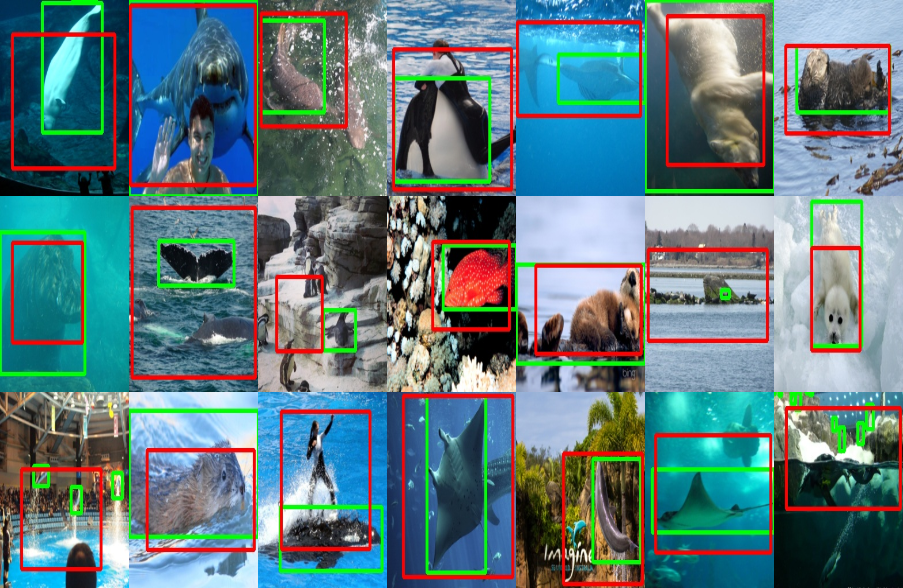

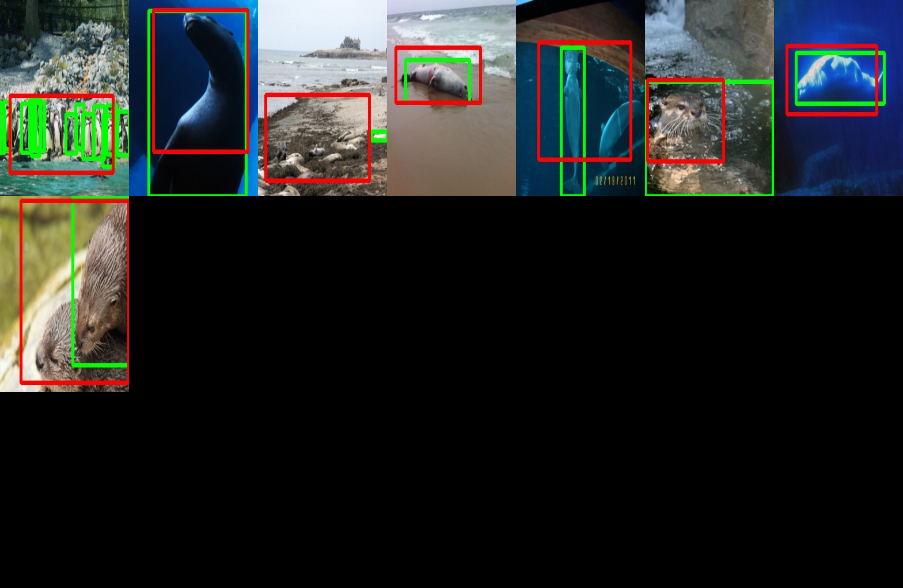

In [35]:

from google.colab.patches import cv2_imshow
for montage in montages:

  cv2_imshow(montage)